<a href="https://colab.research.google.com/github/ArthurStarks/ArthurStarks/blob/main/Cas_pratique_AI_for_Optimal_Power_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install pypower --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.0/347.0 kB 15.2 MB/s eta 0:00:00


In [ ]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

# Deep learning framework
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# For reproducibility
SEED = 2024
torch.manual_seed(SEED)

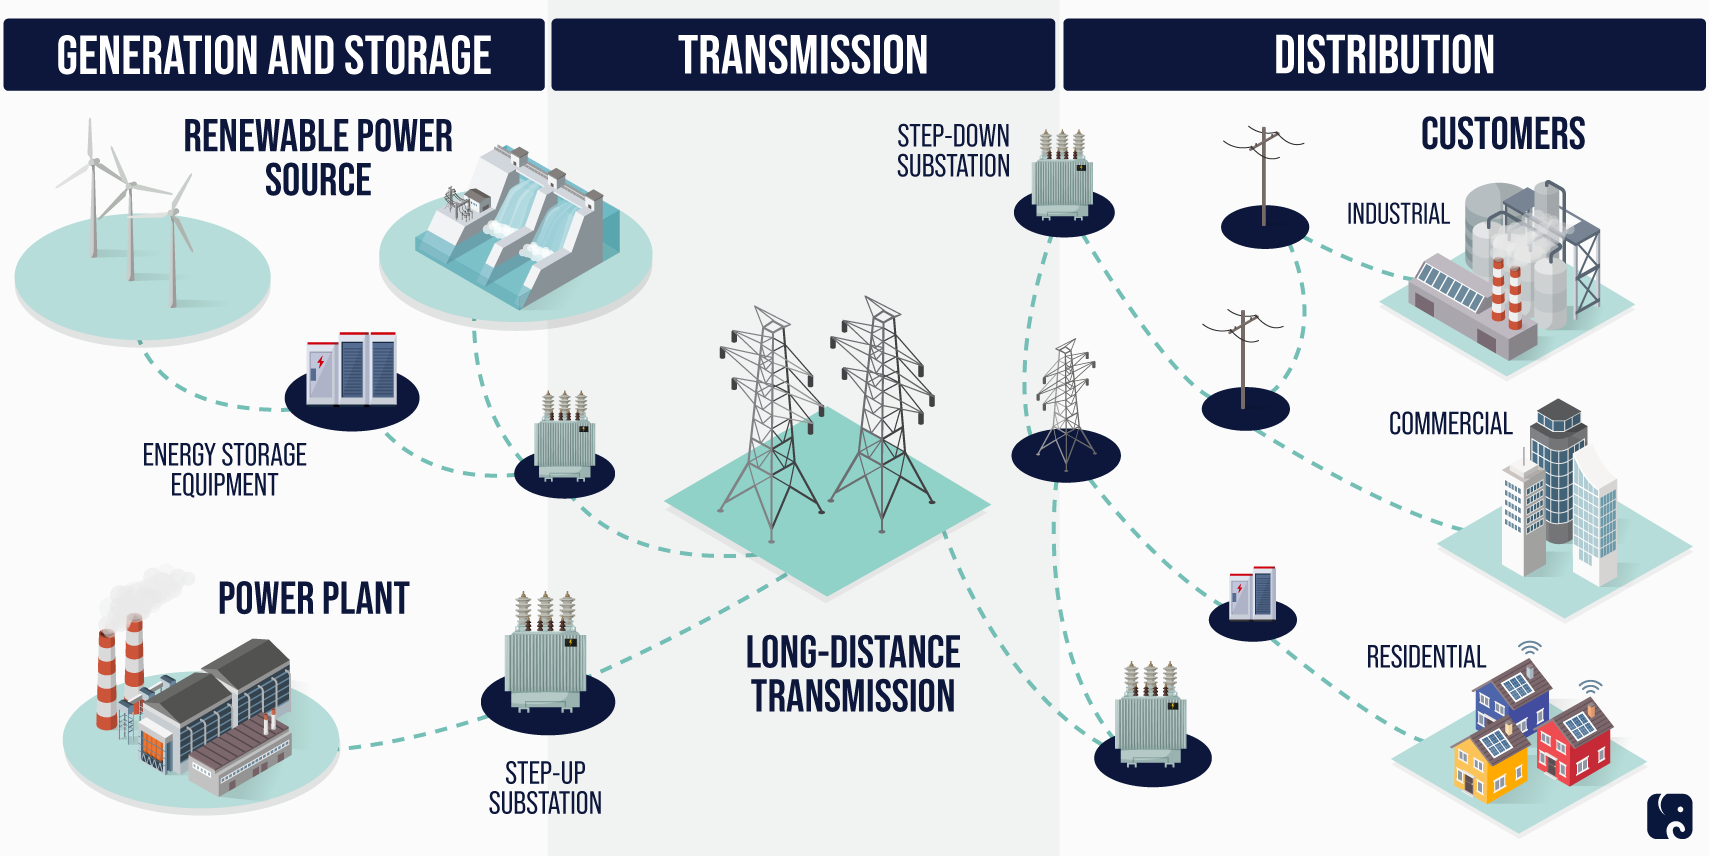

Figure source: [Senate RPC](https://www.rpc.senate.gov/policy-papers/infrastructure-cybersecurity-the-us-electric-grid)

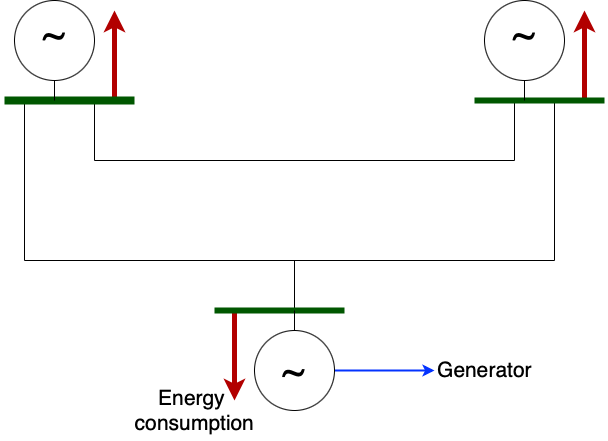

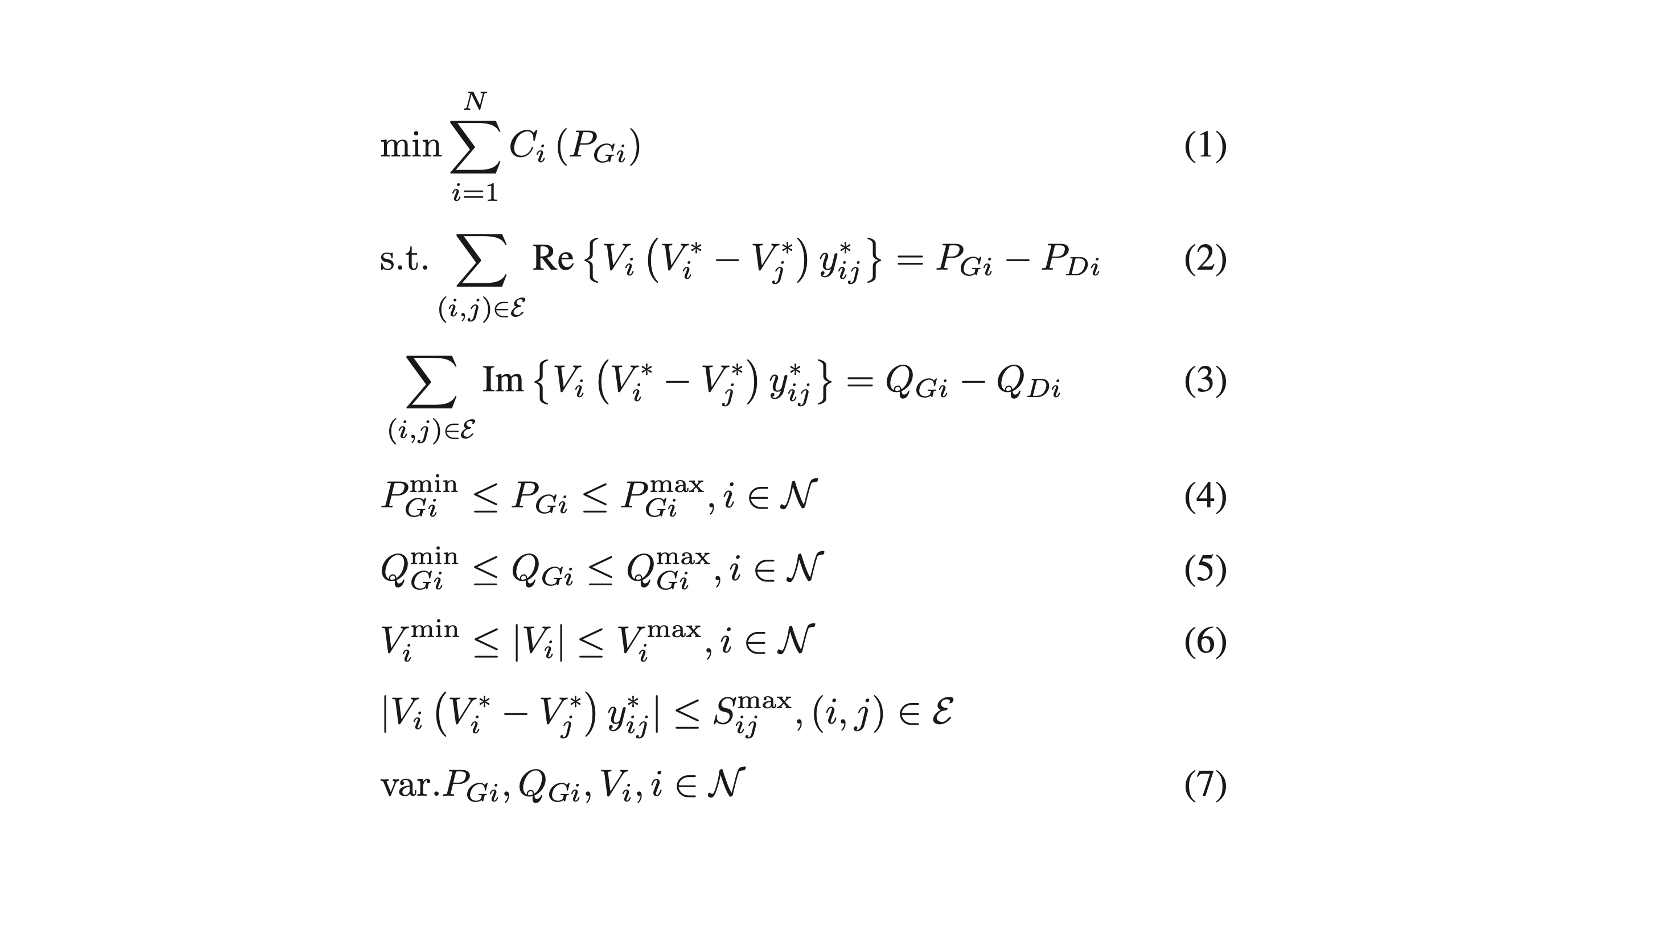

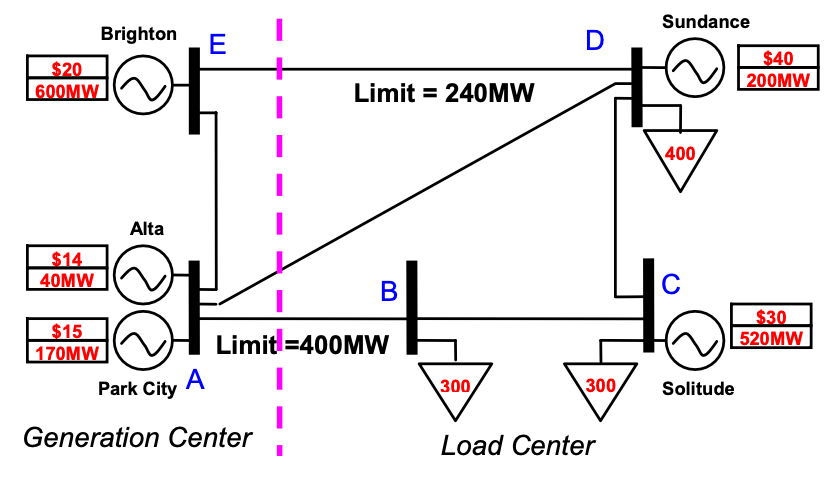

The system is a 5-bus grid with two major zones divided into generation and loads. As you can see from the figure, the nodes represent cities in Utah, MI, in the US. The case file includes a snapshot of the grid including the necessary parameters to calculate a(n) (optimal) power flow calculation. Let's analyze the data step-by-step.

In [ ]:
# Load the network for Case5
net = {
    "baseMVA": 100.0,
## area data
    "areas": np.array([[1, 4]]),
## bus data
###	bus_i	type	Pd	Qd	Gs	Bs	area	Vm	Va	baseKV	zone	Vmax	Vmin
    "bus": np.array([
            [1, 2, 0.0, 0.0, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [2, 1, 300.0, 98.61, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [3, 2, 300.0, 98.61, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [4, 3, 400.0, 131.47, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [5, 2, 0.0, 0.0, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000]
        ]),
## generator data
###	bus	Pg	Qg	Qmax	Qmin	Vg	mBase	status	Pmax	Pmin
    "gen": np.array([
            [1, 20.0, 0.0, 30.0, -30.0, 1.0, 100.0, 1, 40.0, 0.0],
            [1, 85.0, 0.0, 127.5, -127.5, 1.0, 100.0, 1, 170.0, 0.0],
            [3, 260.0, 0.0, 390.0, -390.0, 1.0, 100.0, 1, 520.0, 0.0],
            [4, 100.0, 0.0, 150.0, -150.0, 1.0, 100.0, 1, 200.0, 0.0],
            [5, 300.0, 0.0, 450.0, -450.0, 1.0, 100.0, 1, 600.0, 0.0]
        ]),
## generator cost data
###	2	startup	shutdown	n	c(n-1)	...	c0
    "gencost": np.array([
            [2, 0.0, 0.0, 3, 0.000000, 14.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 15.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 30.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 40.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 10.000000, 0.000000]
        ]),
## branch data
###	fbus	tbus	r	x	b	rateA	rateB	rateC	ratio	angle	status	angmin	angmax
    "branch": np.array([
            [1, 2, 0.00281, 0.0281, 0.00712, 400.0, 400.0, 400.0, 0.0, 0.0, 1, -30.0, 30.0],
            [1, 4, 0.00304, 0.0304, 0.00658, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [1, 5, 0.00064, 0.0064, 0.03126, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [2, 3, 0.00108, 0.0108, 0.01852, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [3, 4, 0.00297, 0.0297, 0.00674, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [4, 5, 0.00297, 0.0297, 0.00674, 240.0, 240.0, 240.0, 0.0, 0.0, 1, -30.0, 30.0]
        ])
}



In [ ]:
bus = pd.DataFrame(net['bus'],
                   columns=['bus_i', 'type',	'Pd',	'Qd',	'Gs',	'Bs',
                            'area',	'Vm',	'Va',	'baseKV',	'zone',	'Vmax',	'Vmin'])
nbus = len(bus)
bus

,bus_i,type,Pd,Qd,Gs,Bs,area,Vm,Va,baseKV,zone,Vmax,Vmin
0,1.0,2.0,0.0,0.00,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
1,2.0,1.0,300.0,98.61,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
2,3.0,2.0,300.0,98.61,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
3,4.0,3.0,400.0,131.47,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9
4,5.0,2.0,0.0,0.00,0.0,0.0,1.0,1.0,0.0,230.0,1.0,1.1,0.9


There are 5 buses in the system, all of them on the same voltage level at 230 kV and in the same zone (1). The voltage can oscillate between 0.9 and 1.1 per unit. (Note: <i>per unit</i> is a type of measurement unit used to express quantities in power systems; we won't get into the details of this measurement system here.)

There are 3 loads with active (MW) and reactive (VAr) power. The biggest is the load at bus 3 with a maximum power consumption of 400 MW.

In [ ]:
gen = pd.DataFrame(net['gen'],
                   columns = ['bus',	'Pg',	'Qg',
                              'Qmax',	'Qmin',	'Vg',
                              'mBase',	'status',	'Pmax',	'Pmin'])
gen

,bus,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin
0,1.0,20.0,0.0,30.0,-30.0,1.0,100.0,1.0,40.0,0.0
1,1.0,85.0,0.0,127.5,-127.5,1.0,100.0,1.0,170.0,0.0
2,3.0,260.0,0.0,390.0,-390.0,1.0,100.0,1.0,520.0,0.0
3,4.0,100.0,0.0,150.0,-150.0,1.0,100.0,1.0,200.0,0.0
4,5.0,300.0,0.0,450.0,-450.0,1.0,100.0,1.0,600.0,0.0


Then, we see the generators with different maximum levels of active and reactive power. Notice that the bus variables indicate where the generator is connected on the grid.

In [ ]:
line = pd.DataFrame(net['branch'],
                    columns = ['fbus',	'tbus',	'r',	'x',	'b',
                               'rateA',	'rateB',	'rateC',	'ratio',
                               'angle',	'status',	'angmin',	'angmax'] )
line

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax
0,1.0,2.0,0.00281,0.0281,0.00712,400.0,400.0,400.0,0.0,0.0,1.0,-30.0,30.0
1,1.0,4.0,0.00304,0.0304,0.00658,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
2,1.0,5.0,0.00064,0.0064,0.03126,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
3,2.0,3.0,0.00108,0.0108,0.01852,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
4,3.0,4.0,0.00297,0.0297,0.00674,426.0,426.0,426.0,0.0,0.0,1.0,-30.0,30.0
5,4.0,5.0,0.00297,0.0297,0.00674,240.0,240.0,240.0,0.0,0.0,1.0,-30.0,30.0


Now, we have 6 lines connecting `from_bus` to `to_bus` with some specific parameters, e.g. resistance (`r`) and reactance (`x`).

In [ ]:
gen_cost = pd.DataFrame(net['gencost'],
                        columns = ['order_poly', 'startup', 'shutdown', 'num_coefficient', 'c2', 'c1', 'c0'])
gen_cost

,order_poly,startup,shutdown,num_coefficient,c2,c1,c0
0,2.0,0.0,0.0,3.0,0.0,14.0,0.0
1,2.0,0.0,0.0,3.0,0.0,15.0,0.0
2,2.0,0.0,0.0,3.0,0.0,30.0,0.0
3,2.0,0.0,0.0,3.0,0.0,40.0,0.0
4,2.0,0.0,0.0,3.0,0.0,10.0,0.0


Up until this point, the grid data is static just as a snapshot, and includes data for all parameters, e.g., minimum and maximum voltage at each node, minimum and maximum active and reactive power generation, generation costs, etc.

After looking at the data, we can solve the AC-OPF problem over this power grid configuration. We use [PyPower](https://rwl.github.io/PYPOWER/api/), a Python-based power system solver, to solve the complex AC-OPF problem.

In [ ]:
# import the solver and solver options from pypower
from pypower.api import runopf, ppoption

# Run power flow to get results
option = ppoption(OUT_ALL=-1) # set the output details
result = runopf(net, option) # run the ACOPF

PYPOWER Version 5.1.16, 05-March-2023 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 1.75 seconds
Objective Function Value = 17551.89 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              5     Total Gen Capacity    1530.0       -1147.5 to 1147.5
Generators         5     On-line Capacity      1530.0       -1147.5 to 1147.5
Committed Gens     5     Generation (actual)   1005.2             371.7
Loads              3     Load                  1000.0             328.7
  Fixed            3       Fixed               1000.0             328.7
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           6     Losses (I^2 * Z)   

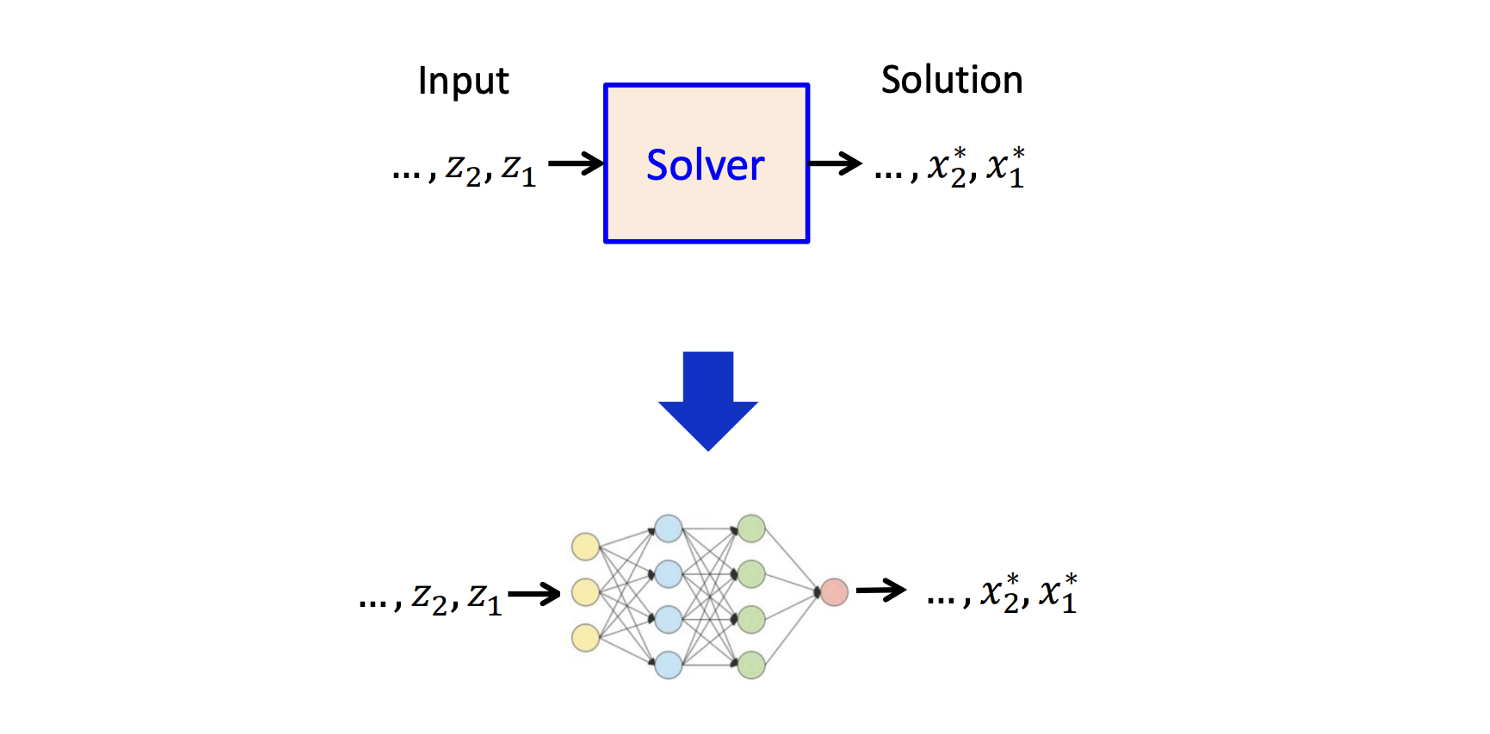

Figure source: [DeepOPF](https://www.mhchen.com/papers/OPF.DeepOPF.SGC.23.pdf)

In [ ]:
from pypower import idx_bus, idx_gen, idx_brch
from tqdm import tqdm

nbus = len(net['bus'])
ngen = len(net['gen'])
basemva = net['baseMVA']
PD_base = net['bus'][:, idx_bus.PD]
QD_base = net['bus'][:, idx_bus.QD]

## Let's consider a small datasize
data_size = 10
## We randomly sample load demand from its default value
PD_data = PD_base * np.random.uniform(0.9,1.1,[data_size, 1])
QD_data = QD_base * np.random.uniform(0.9,1.1,[data_size, 1])
PG_data = np.zeros([data_size, ngen])
QG_data = np.zeros([data_size, ngen])
VM_data = np.zeros([data_size, nbus])
VA_data = np.zeros([data_size, nbus])
## Then, for each load demand, we run the solver to obtain the optimal solution.
for i in tqdm(range(data_size)):
  net['bus'][:, idx_bus.PD] = PD_data[i]
  net['bus'][:, idx_bus.QD] = QD_data[i]
  option = ppoption(VERBOSE=0, OUT_ALL=0)
  result = runopf(net, option)
  PG_data[i] = result['gen'][:, idx_gen.PG]
  QG_data[i] = result['gen'][:, idx_gen.QG]
  VM_data[i] = result['bus'][:, idx_bus.VM]
  VA_data[i] = result['bus'][:, idx_bus.VA]


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


In [ ]:
# Download data
!mkdir data
!wget https://data.nrel.gov/system/files/177/pglib_opf_case5_pjm.csv -P data/

--2024-07-29 08:30:27--  https://data.nrel.gov/system/files/177/pglib_opf_case5_pjm.csv
Resolving data.nrel.gov (data.nrel.gov)... 13.248.240.147, 76.223.107.85
Connecting to data.nrel.gov (data.nrel.gov)|13.248.240.147|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nrel-datacat-public-prod.s3.us-west-2.amazonaws.com/files/177/pglib_opf_case5_pjm.csv?response-content-disposition=attachment%3B%20filename%3Dpglib_opf_case5_pjm.csv&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEEAaCXVzLXdlc3QtMiJHMEUCIF8Y7S%2FFM9JkNc5FOctyyO3aJneWwa8Pel0O7THIRd5sAiEA71PcnXNnhiwI%2BYPzVhHhhaODvgicpluCmXXiCxHYqGEq5QMIKRAAGgw5OTE0MDQ5NTYxOTQiDA1D5ov0pQXNB9ioAirCA7vKsr79OyWC0POpFLySkGLTE2Qa7GtkyJHFPikZbehGN9JJFGBFYkg1GjR5Xc53d7P1%2BFiyWsRRC28ZIHAGcY9poDpLeytCkuEMjOcz5n5Kxp%2FYXEdIqg0G1gG8bjFTzToc6YaZlffdAjRKReoQ3hIwQsNvFcHRGNjA0IXNVQg7hMBJWt7XKHspWwZ6htHQP%2B0A0y0e0UhQGBfL3YvsoKluDwxodGcNM2EwXziXmZ2H3JCg86e1BKkppyfhUYFdsMvk8dAjQDI7Fx26D%2BfR

In [ ]:
df = pd.read_csv('data/pglib_opf_case5_pjm.csv')
df.head()

,load1:pl,load2:pl,load3:pl,load1:ql,load2:ql,load3:ql,gen1:pg,gen2:pg,gen3:pg,gen4:pg,...,line3:p_fr_max,line4:p_fr_max,line5:p_fr_max,line6:p_fr_max,line1:q_fr_max,line2:q_fr_max,line3:q_fr_max,line4:q_fr_max,line5:q_fr_max,line6:q_fr_max
0,6.570765,2.275993,4.051883,4.376283,0.628149,4.026378,0.4,1.7,4.876424,1.558644,...,-0.000002,-0.000003,-2.720498e-07,-0.000006,0.000000e+00,0.0,-7.933284e-07,-1.873404e-06,0.0,-3.069352e-06
1,6.552550,1.704638,4.090173,4.400894,0.724693,3.937011,0.4,1.7,4.317437,1.531758,...,-0.000002,-0.000003,-2.624331e-07,-0.000006,0.000000e+00,0.0,-7.848656e-07,-1.892890e-06,0.0,-2.936123e-06
2,5.645406,2.029723,5.955067,1.377338,0.865517,3.240306,0.4,1.7,5.199999,1.490930,...,-0.000002,-0.000002,0.000000e+00,-0.000280,-1.365476e-07,0.0,0.000000e+00,-8.479213e-07,0.0,-3.177477e-07
3,4.778645,2.417017,6.361179,0.843277,0.881531,2.635903,0.4,1.7,5.200000,1.644658,...,-0.000001,-0.000001,0.000000e+00,-0.647117,-3.141235e-07,0.0,0.000000e+00,-7.238938e-07,0.0,-6.550166e-09
4,5.690040,2.458801,5.745494,2.003454,1.119158,3.286294,0.4,1.7,5.200000,1.684051,...,-0.000002,-0.000002,-5.028490e-09,-0.000067,0.000000e+00,0.0,0.000000e+00,-9.201327e-07,0.0,-6.686726e-07


In [ ]:
df.shape

(10000, 104)

In [ ]:
df.columns

Index(['load1:pl', 'load2:pl', 'load3:pl', 'load1:ql', 'load2:ql', 'load3:ql',
       'gen1:pg', 'gen2:pg', 'gen3:pg', 'gen4:pg',
       ...
       'line3:p_fr_max', 'line4:p_fr_max', 'line5:p_fr_max', 'line6:p_fr_max',
       'line1:q_fr_max', 'line2:q_fr_max', 'line3:q_fr_max', 'line4:q_fr_max',
       'line5:q_fr_max', 'line6:q_fr_max'],
      dtype='object', length=104)

In [ ]:
# Define input columns
load_p = list(df.columns[0:3])
load_q = list(df.columns[3:6])
inputs = load_p + load_q
print(inputs)

['load1:pl', 'load2:pl', 'load3:pl', 'load1:ql', 'load2:ql', 'load3:ql']


In [ ]:
# Define output columns
gen_p = list(df.columns[6:11])
gen_q = list(df.columns[11:16])
def convert(x):
    # Remove spaces around the '+' or '-' before 'j'
    x = x.replace(" + ", "+").replace(" - ", "-").replace("j", "j").strip()
    return np.complex64(x)
bus_vm = []
bus_va = []
for bus_v_column in df.columns[21:26]:
  df[bus_v_column + '_mag'] = df[bus_v_column].apply(convert).apply(np.abs)
  bus_vm.append(bus_v_column + '_mag')
  df[bus_v_column + '_ang'] = df[bus_v_column].apply(convert).apply(np.angle)
  ## the follow line of code is to correct a bug in the OPFLearn dataset
  df[bus_v_column + '_ang'] = -1*np.rad2deg(df[bus_v_column + '_ang'].values)
  bus_va.append(bus_v_column + '_ang')
outputs = gen_p + gen_q + bus_vm + bus_va
print(outputs)

['gen1:pg', 'gen2:pg', 'gen3:pg', 'gen4:pg', 'gen5:pg', 'gen1:qg', 'gen2:qg', 'gen3:qg', 'gen4:qg', 'gen5:qg', 'bus1:v_bus_mag', 'bus2:v_bus_mag', 'bus3:v_bus_mag', 'bus4:v_bus_mag', 'bus5:v_bus_mag', 'bus1:v_bus_ang', 'bus2:v_bus_ang', 'bus3:v_bus_ang', 'bus4:v_bus_ang', 'bus5:v_bus_ang']


In [ ]:
def plot_hist_variables(variables):
    fig, axs = plt.subplots(nrows=1, ncols=len(variables), figsize=(16, 3))
    for i, input_name in enumerate(variables):
        axs[i].hist(df[input_name], bins=10, density=True)
        axs[i].set_title(input_name, fontsize=18)
        mean_value = df[input_name].mean()
        axs[i].axvline(mean_value, color='k', linestyle='dashed', linewidth=2)
        x_offset = axs[i].get_xlim()[1] * 0.02
        y_offset = axs[i].get_ylim()[1] * 0.05
        axs[i].annotate(f"Mean: {mean_value:.2f}", xy=(mean_value, axs[i].get_ylim()[1]),
                        xytext=(mean_value+x_offset, axs[i].get_ylim()[1]-y_offset),
                        ha='left', va='top', fontsize=14,
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        if 'pl' in input_name: axs[i].set_xlabel('active load (p.u.)', fontsize=14)
        elif 'ql' in input_name: axs[i].set_xlabel('reactive load (p.u.)', fontsize=14)
        elif 'pg' in input_name: axs[i].set_xlabel('active gen (p.u.)', fontsize=14)
        elif 'qg' in input_name: axs[i].set_xlabel('reactive gen (p.u.)', fontsize=14)
        elif 'mag' in input_name: axs[i].set_xlabel('bus vol. mag. (p.u.)', fontsize=14)
        elif 'ang' in input_name: axs[i].set_xlabel('bus vol. ang. (rad.)', fontsize=14)
    fig.tight_layout()
    plt.show()

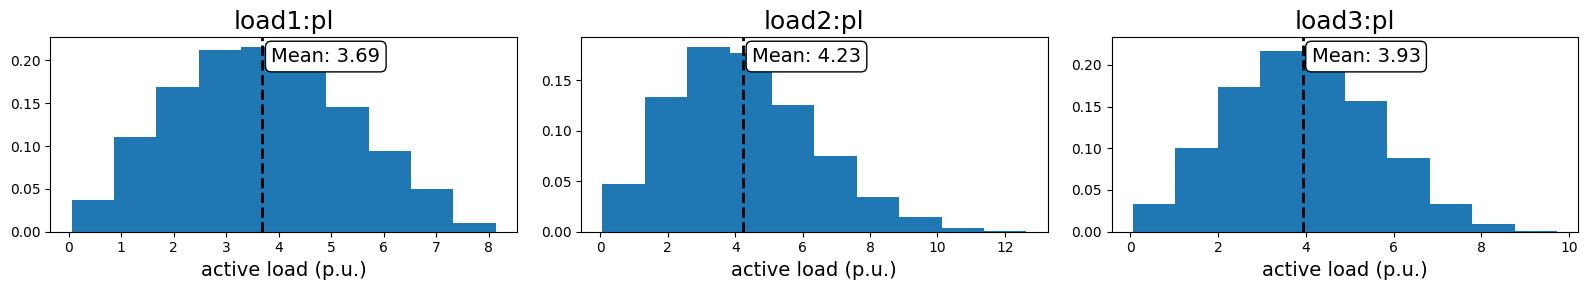

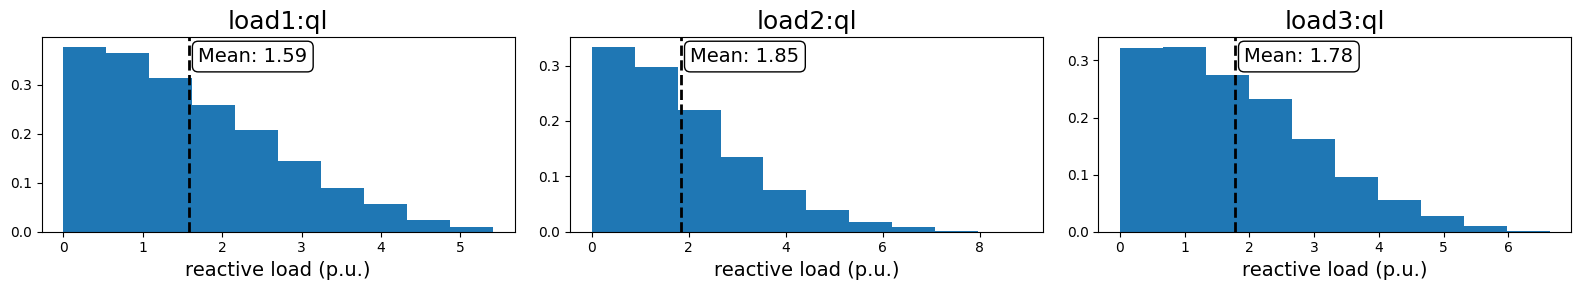

In [ ]:
plot_hist_variables(load_p)
plot_hist_variables(load_q)

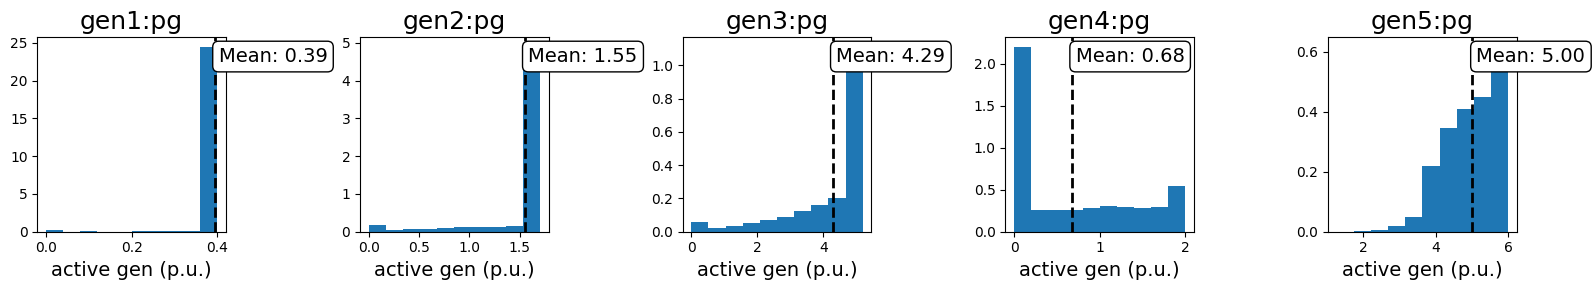

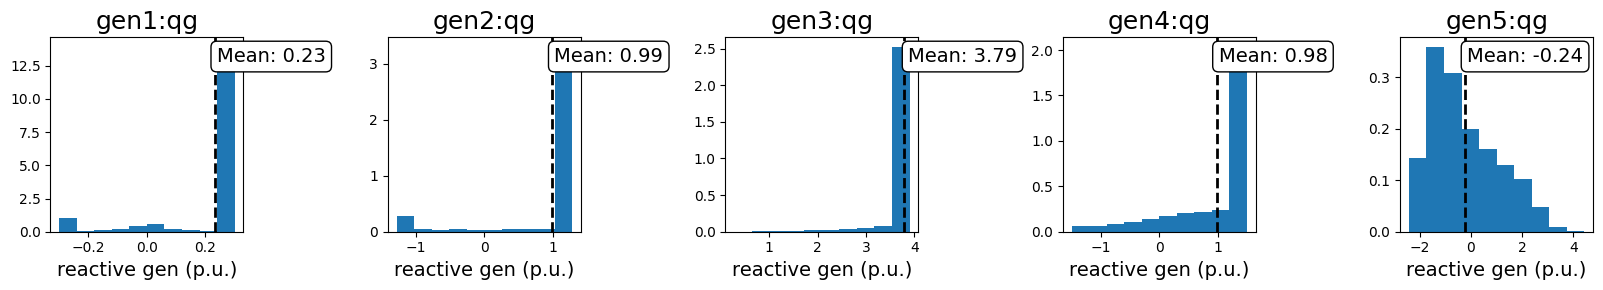

In [ ]:
plot_hist_variables(gen_p)
plot_hist_variables(gen_q)

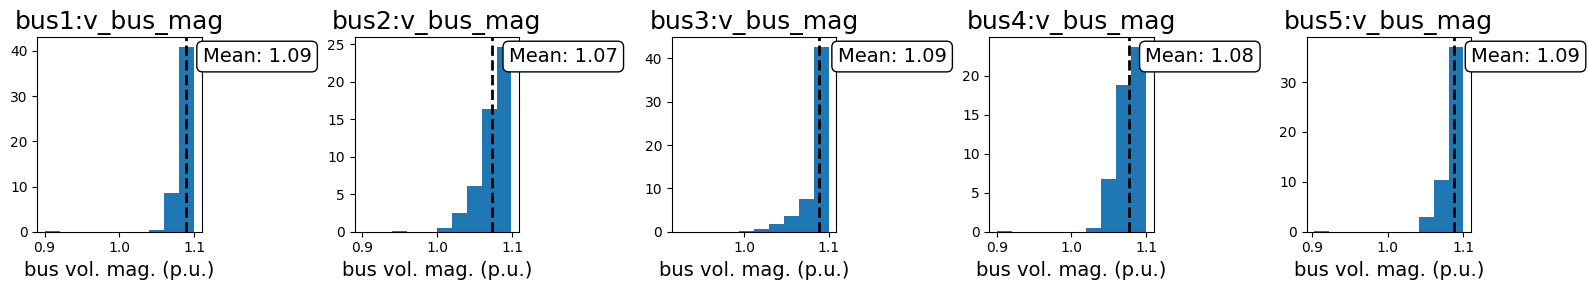

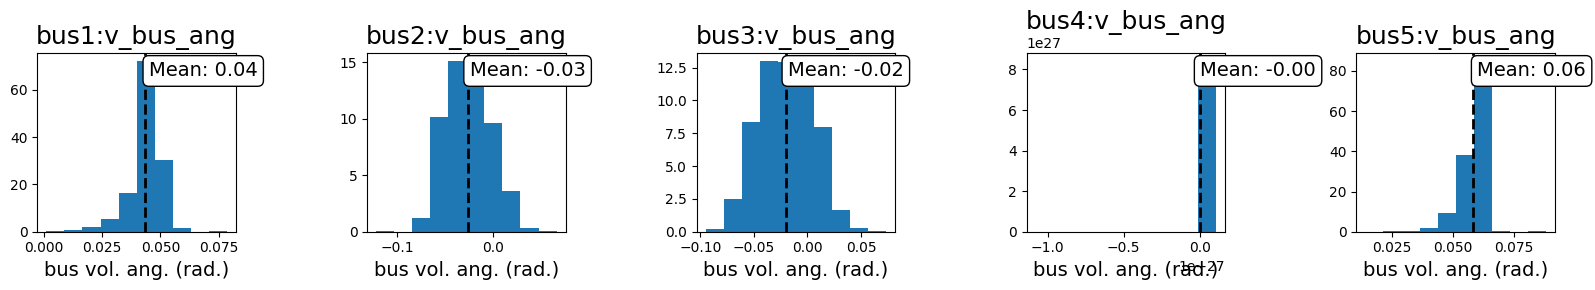

In [ ]:
plot_hist_variables(bus_vm)
plot_hist_variables(bus_va)

In [ ]:
torch.cuda.is_available()
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
# Define a simple NN model
class NeuralNetwork(nn.Module):
    def __init__(self, x_size=3, y_size=5, width=32, depth=2):
        super().__init__()
        NN = [nn.Linear(x_size, width)]
        for _ in range(depth):
          NN.append(nn.Linear(width, width))
          NN.append(nn.ReLU())
        NN.append(nn.Linear(width, y_size))
        self.NN = nn.Sequential(*NN)

    def forward(self, x):
        y = self.NN(x)
        return y

model_base = NeuralNetwork(x_size=len(inputs),
                      y_size=len(outputs),
                      width=32,
                      depth=2).to(device)
print(f'NN with input dim {len(inputs)} and outpput dim {len(outputs)}')

NN with input dim 6 and outpput dim 20


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_base.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    with torch.enable_grad():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)
          # Backpropagation

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          if batch % 10 == 0:
              loss, current = loss.item(), (batch) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [ ]:
class OPFDataset(Dataset):
    def __init__(self, data, inputs, outputs):
        self.data = data
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = torch.tensor(self.data.iloc[idx,:len(self.inputs)].values).to(torch.float32)
        output = torch.tensor(self.data.iloc[idx, len(self.inputs):].values).to(torch.float32)
        return input, output

In [ ]:
data = df[inputs + outputs]
train_data = data.sample(frac=0.8, random_state=SEED)
test_data = data.drop(train_data.index)
print(f'training data size: f{train_data.shape}, test data size: {test_data.shape}')

training data size: f(8000, 26), test data size: (2000, 26)


In [ ]:
train_dataloader = DataLoader(OPFDataset(train_data, inputs, outputs),
                              batch_size=128, shuffle=True)
test_dataloader = DataLoader(OPFDataset(test_data, inputs, outputs),
                             batch_size=128, shuffle=True)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_base, loss_fn, optimizer)
    test(test_dataloader, model_base, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.082420  [    0/ 8000]
loss: 3.606107  [ 1280/ 8000]
loss: 3.016641  [ 2560/ 8000]
loss: 2.106516  [ 3840/ 8000]
loss: 1.059224  [ 5120/ 8000]
loss: 0.558837  [ 6400/ 8000]
loss: 0.359040  [ 7680/ 8000]
Test Error: 
 Avg loss: 0.325342 

Epoch 2
-------------------------------
loss: 0.323879  [    0/ 8000]
loss: 0.287021  [ 1280/ 8000]
loss: 0.251586  [ 2560/ 8000]
loss: 0.265715  [ 3840/ 8000]
loss: 0.276212  [ 5120/ 8000]
loss: 0.258445  [ 6400/ 8000]
loss: 0.234806  [ 7680/ 8000]
Test Error: 
 Avg loss: 0.248940 

Epoch 3
-------------------------------
loss: 0.247237  [    0/ 8000]
loss: 0.254586  [ 1280/ 8000]
loss: 0.261471  [ 2560/ 8000]
loss: 0.224545  [ 3840/ 8000]
loss: 0.228759  [ 5120/ 8000]
loss: 0.214557  [ 6400/ 8000]
loss: 0.209436  [ 7680/ 8000]
Test Error: 
 Avg loss: 0.202158 

Epoch 4
-------------------------------
loss: 0.211896  [    0/ 8000]
loss: 0.169675  [ 1280/ 8000]
loss: 0.177801  [ 2560/ 8000]
loss: 0.196813 

In [ ]:
batch_snapshot = next(iter(test_dataloader))
snapshot_x, snapshot_y = batch_snapshot[0][[0]], batch_snapshot[1][[0]]

In [ ]:
snapshot_x

tensor([[2.4994, 5.3052, 4.5316, 0.8896, 2.2668, 1.2205]])

In [ ]:
snapshot_y

tensor([[ 4.0000e-01,  1.7000e+00,  5.2000e+00,  4.9790e-01,  4.5809e+00,
          3.0000e-01,  1.2750e+00,  3.9000e+00,  5.4139e-01, -1.3053e+00,
          1.0946e+00,  1.0900e+00,  1.1000e+00,  1.0833e+00,  1.0882e+00,
          4.8056e-02, -7.9392e-03, -7.6186e-03,  5.1292e-34,  6.0469e-02]])

In [ ]:
import time
st = time.time()
with torch.no_grad():
    snapshot_pred = model_base(snapshot_x.to(device))
et = time.time()

In [ ]:
et-st

0.0018854141235351562

In [ ]:
loss_fn(snapshot_pred, snapshot_y.to(device)).item()

0.026148740202188492

In [ ]:
# Let's find the generation cost
linear_cost = net['gencost'][:,5]
cost_coef = torch.tensor(linear_cost).to(torch.float32)
def calculate_grid_cost(outputs, cost_coef):
  """Function to calculate grid costs based on generator levels."""
  pg = outputs[:, :5]
  return (pg * cost_coef).sum(1)

In [ ]:
pred_grid_cost = calculate_grid_cost(snapshot_pred, cost_coef)[0]
opt_grid_cost = calculate_grid_cost(snapshot_y, cost_coef)[0]
print(f"grid_cost for predicted solution is {pred_grid_cost:.4f}")
print(f"grid_cost for optimal solution is {opt_grid_cost:.4f}")
print(f"optimality gap is {(pred_grid_cost - opt_grid_cost)/(opt_grid_cost)*100:.2f}%")

grid_cost for predicted solution is 257.5766
grid_cost for optimal solution is 252.8253
optimality gap is 1.88%


In [ ]:
basemva = net['baseMVA']
pg_max = gen['Pmax'].values / basemva
pg_min = gen['Pmin'].values / basemva
qg_max = gen['Qmax'].values / basemva
qg_min = gen['Qmin'].values / basemva
vm_max = bus['Vmax'].values
vm_min = bus['Vmin'].values
va_max = [np.pi for i in range(len(bus))]
va_min = [-np.pi for i in range(len(bus))]

outputs_min = np.concatenate([pg_min, qg_min, vm_min, va_min])
outputs_max = np.concatenate([pg_max, qg_max, vm_max, va_max])
outputs_min = torch.as_tensor(outputs_min).to(torch.float32).view(1,-1)
outputs_max = torch.as_tensor(outputs_max).to(torch.float32).view(1,-1)

def upper_lower_bound_constraint(outputs, outputs_max, output_min):
  return torch.relu(outputs - outputs_max) + torch.relu(outputs_min - outputs)

In [ ]:
vio_1 = upper_lower_bound_constraint(snapshot_pred, outputs_max, outputs_min)
print(f'total upper/lower bound violation: {vio_1.sum():.4f}')

total upper/lower bound violation: 0.0882


In [ ]:
from pypower.api import makeYbus, ext2int
net = ext2int(net)
# Calculate the bus admittance matrix (Ybus) and branch admittance matrices (Yf, Yt)
Ybus, Yf, Yt = makeYbus(net['baseMVA'], net['bus'], net['branch'])
Ybus = Ybus.todense()
Yf = Yf.todense()
gen_bus_index = net['gen'][:,idx_gen.GEN_BUS]
load_bus_index = [i for i in range(5) if net['bus'][i, idx_bus.PD]>0]

def gen_load_to_bus(inputs, outputs):
  batch = inputs.shape[0]
  pd = inputs[:, :3]
  qd = inputs[:, 3:]
  pg = outputs[:, 0:5]
  qg = outputs[:, 5:10]
  bus_pg = torch.zeros([batch, 5])
  bus_qg = torch.zeros([batch, 5])
  for i, bus_index in enumerate(gen_bus_index):
    bus_pg[:,int(bus_index)] += pg[:, i]
    bus_qg[:,int(bus_index)] += qg[:, i]

  bus_pd = torch.zeros([batch, 5])
  bus_qd = torch.zeros([batch, 5])
  for i, bus_index in enumerate(load_bus_index):
    bus_pd[:,bus_index] += pd[:, i]
    bus_qd[:,bus_index] += qd[:, i]

  return bus_pg, bus_qg, bus_pd, bus_qd

def power_flow_constraint(inputs, outputs, Ybus):
  bus_pg, bus_qg, bus_pd, bus_qd = gen_load_to_bus(inputs, outputs)
  bus_p_inj = bus_pg - bus_pd
  bus_q_inj = bus_qg - bus_qd
  vm, va = outputs[:, 10:15], outputs[:, 15:20]
  # v = vm * np.exp(1j * va)
  # I = np.matmul(v, Ybus)
  # P = np.multiply(v,I.conj())
  vr = vm * torch.cos(va)
  vi = vm * torch.sin(va)
  Ir = vr @ Ybus.real - vi @ Ybus.imag
  Ii = vi @ Ybus.real + vr @ Ybus.imag
  bus_p = (vr * Ir) + (vi * Ii)
  bus_q = (vi * Ir) - (vr * Ii)

  return torch.abs(bus_p_inj - bus_p), torch.abs(bus_q_inj - bus_q)

In [ ]:
act_mis, rea_mis = power_flow_constraint(snapshot_x, snapshot_pred, Ybus)
print(f'total active power mismatch: {act_mis.sum():.4f}, ' \
      f'total reactive power mismatch: {rea_mis.sum():.4f}')

total active power mismatch: 13.5465, total reactive power mismatch: 14.9095


In [ ]:
def branch_flow_constraont(outputs, Yf, Yt, line):
  fbus = line['fbus'].apply(int).values - 1
  tbus = line['tbus'].apply(int).values - 1
  vm, va = outputs[:, 10:15], outputs[:, 15:20]
  vr = vm * torch.cos(va)
  vi = vm * torch.sin(va)
  Ir = vr @ Yf.real.T - vi @ Yf.imag.T
  Ii = vi @ Yf.real.T + vr @ Yf.imag.T
  branch_p = torch.multiply(vr[:, fbus], Ir) + torch.multiply(vi[:,fbus], Ii)
  branch_q = torch.multiply(vi[:, fbus], Ir) - torch.multiply(vr[:,fbus], Ii)
  s = torch.sqrt((torch.square(branch_p) +  torch.square(branch_q)))
  smax = line['rateA'].values / 100

  branch_ang = torch.abs(va[:, fbus] - va[:, tbus])
  angmax = np.deg2rad(line['angmax'].values)

  return torch.relu(s-smax ), torch.relu(branch_ang - angmax)

In [ ]:
flow, angle = branch_flow_constraont(snapshot_pred, Yf, Yt, line)
print(f'branch flow violation: {flow.sum():.4f}, ',\
      f'branch angle violation: {angle.max():.4f}')

branch flow violation: 0.9854,  branch angle violation: 0.0000


In [ ]:
!pip install pypower --quiet

In [ ]:
# Data visualization
import matplotlib.pyplot as plt
# Data manipulation
import pandas as pd
import numpy as np
import os
# Deep learning framework
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pypower import idx_bus, idx_gen, idx_brch, idx_cost
from pypower.api import makeYbus, ext2int

# For reproducibility
SEED = 2024
torch.manual_seed(SEED)
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
# Load the network for Case5
net = {
    "baseMVA": 100.0,
## area data
    "areas": np.array([[1, 4]]),
## bus data
###	bus_i	type	Pd	Qd	Gs	Bs	area	Vm	Va	baseKV	zone	Vmax	Vmin
    "bus": np.array([
            [1, 2, 0.0, 0.0, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [2, 1, 300.0, 98.61, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [3, 2, 300.0, 98.61, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [4, 3, 400.0, 131.47, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000],
            [5, 2, 0.0, 0.0, 0.0, 0.0, 1, 1.00000, 0.00000, 230.0, 1, 1.10000, 0.90000]
        ]),
## generator data
###	bus	Pg	Qg	Qmax	Qmin	Vg	mBase	status	Pmax	Pmin
    "gen": np.array([
            [1, 20.0, 0.0, 30.0, -30.0, 1.0, 100.0, 1, 40.0, 0.0],
            [1, 85.0, 0.0, 127.5, -127.5, 1.0, 100.0, 1, 170.0, 0.0],
            [3, 260.0, 0.0, 390.0, -390.0, 1.0, 100.0, 1, 520.0, 0.0],
            [4, 100.0, 0.0, 150.0, -150.0, 1.0, 100.0, 1, 200.0, 0.0],
            [5, 300.0, 0.0, 450.0, -450.0, 1.0, 100.0, 1, 600.0, 0.0]
        ]),
## generator cost data
###	2	startup	shutdown	n	c(n-1)	...	c0
    "gencost": np.array([
            [2, 0.0, 0.0, 3, 0.000000, 14.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 15.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 30.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 40.000000, 0.000000],
            [2, 0.0, 0.0, 3, 0.000000, 10.000000, 0.000000]
        ]),
## branch data
###	fbus	tbus	r	x	b	rateA	rateB	rateC	ratio	angle	status	angmin	angmax
    "branch": np.array([
            [1, 2, 0.00281, 0.0281, 0.00712, 400.0, 400.0, 400.0, 0.0, 0.0, 1, -30.0, 30.0],
            [1, 4, 0.00304, 0.0304, 0.00658, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [1, 5, 0.00064, 0.0064, 0.03126, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [2, 3, 0.00108, 0.0108, 0.01852, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [3, 4, 0.00297, 0.0297, 0.00674, 426, 426, 426, 0.0, 0.0, 1, -30.0, 30.0],
            [4, 5, 0.00297, 0.0297, 0.00674, 240.0, 240.0, 240.0, 0.0, 0.0, 1, -30.0, 30.0]
        ])
}

In [ ]:
# Load the training dataset
if not os.path.exists('data/pglib_opf_case5_pjm.csv'):
  # Download data
  !mkdir data
  !wget https://data.nrel.gov/system/files/177/pglib_opf_case5_pjm.csv -P data/
df = pd.read_csv('data/pglib_opf_case5_pjm.csv')

# Define input columns
# Define input columns
load_p = list(df.columns[0:3])
load_q = list(df.columns[3:6])
inputs = load_p + load_q
print(inputs)
# Define output columns
gen_p = list(df.columns[6:11])
gen_q = list(df.columns[11:16])
def convert(x):
    # Remove spaces around the '+' or '-' before 'j'
    x = x.replace(" + ", "+").replace(" - ", "-").replace("j", "j").strip()
    return np.complex64(x)
bus_vm = []
bus_va = []
for bus_v_column in df.columns[21:26]:
  df[bus_v_column + '_mag'] = df[bus_v_column].apply(convert).apply(np.abs)
  bus_vm.append(bus_v_column + '_mag')
  df[bus_v_column + '_ang'] = df[bus_v_column].apply(convert).apply(np.angle)
  df[bus_v_column + '_ang'] = -1*np.rad2deg(df[bus_v_column + '_ang'].values)
  bus_va.append(bus_v_column + '_ang')
outputs = gen_p + gen_q + bus_vm + bus_va
print(outputs)

class OPFDataset(Dataset):
    def __init__(self, data, inputs, outputs):
        self.data = data
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = torch.tensor(self.data.iloc[idx,:len(self.inputs)].values).to(torch.float32)
        output = torch.tensor(self.data.iloc[idx, len(self.inputs):].values).to(torch.float32)
        return input, output

data = df[inputs + outputs]
train_data = data.sample(frac=0.8, random_state=SEED)
test_data = data.drop(train_data.index)
train_dataloader = DataLoader(OPFDataset(train_data, inputs, outputs),
                              batch_size=128, shuffle=True)
test_dataloader = DataLoader(OPFDataset(test_data, inputs, outputs),
                             batch_size=128, shuffle=True)

['load1:pl', 'load2:pl', 'load3:pl', 'load1:ql', 'load2:ql', 'load3:ql']
['gen1:pg', 'gen2:pg', 'gen3:pg', 'gen4:pg', 'gen5:pg', 'gen1:qg', 'gen2:qg', 'gen3:qg', 'gen4:qg', 'gen5:qg', 'bus1:v_bus_mag', 'bus2:v_bus_mag', 'bus3:v_bus_mag', 'bus4:v_bus_mag', 'bus5:v_bus_mag', 'bus1:v_bus_ang', 'bus2:v_bus_ang', 'bus3:v_bus_ang', 'bus4:v_bus_ang', 'bus5:v_bus_ang']


In [ ]:
# Define the evaluation metric as we did in the discussion
class OPF_metric():
  def __init__(self, net):
    basemva = net['baseMVA']
    linear_cost = net['gencost'][:, 5]
    self.cost_coef = torch.tensor(linear_cost).to(torch.float32)

    pg_max = net['gen'][:, idx_gen.PMAX] / basemva
    pg_min = net['gen'][:, idx_gen.PMIN] / basemva
    qg_max = net['gen'][:, idx_gen.QMAX] / basemva
    qg_min = net['gen'][:, idx_gen.QMIN] / basemva
    vm_max = net['bus'][:, idx_bus.VMAX]
    vm_min = net['bus'][:, idx_bus.VMIN]
    va_max = [np.pi/2 for i in range(len(net['bus']))]
    va_min = [-np.pi/2 for i in range(len(net['bus']))]
    outputs_min = np.concatenate([pg_min, qg_min, vm_min, va_min])
    outputs_max = np.concatenate([pg_max, qg_max, vm_max, va_max])
    self.outputs_min = torch.as_tensor(outputs_min).to(torch.float32).view(1,-1)
    self.outputs_max = torch.as_tensor(outputs_max).to(torch.float32).view(1,-1)

    # Calculate the bus admittance matrix (Ybus) and branch admittance matrices (Yf, Yt)
    net = ext2int(net)
    Ybus, Yf, Yt = makeYbus(net['baseMVA'], net['bus'], net['branch'])
    Ybus = Ybus.todense()
    self.Ybus_real = torch.as_tensor(Ybus.real).to(torch.float32)
    self.Ybus_imag = torch.as_tensor(Ybus.imag).to(torch.float32)
    Yf = Yf.todense()
    Yt = Yt.todense()
    self.Yf_real = torch.as_tensor(Yf.real).to(torch.float32)
    self.Yf_imag = torch.as_tensor(Yf.imag).to(torch.float32)
    self.Yt_real = torch.as_tensor(Yt.real).to(torch.float32)
    self.Yt_imag = torch.as_tensor(Yt.imag).to(torch.float32)

    self.gen_bus_index = net['gen'][:,idx_gen.GEN_BUS]
    self.load_bus_index = [i for i in range(5) if net['bus'][i, idx_bus.PD]>0]

    self.fbus = net['branch'][:, idx_brch.F_BUS].astype(int)
    self.tbus = net['branch'][:, idx_brch.T_BUS].astype(int)
    self.smax =  torch.as_tensor(net['branch'][:, idx_brch.RATE_A] / basemva).to(torch.float32)
    self.angmax = torch.as_tensor(np.deg2rad(net['branch'][:, idx_brch.ANGMAX])).to(torch.float32)

  # Let's find the generation cost
  def cal_gen_cost(self, outputs):
    pg = outputs[:, :5]
    return (pg * self.cost_coef).sum(1)

  def cal_upper_lower_bound_violation(self, outputs):
    vio_1 = torch.relu(outputs - self.outputs_max)
    vio_2 =  torch.relu(self.outputs_min - outputs)
    return vio_1 + vio_2

  def cal_power_balance_violation(self, inputs, outputs):
    bus_pg, bus_qg, bus_pd, bus_qd = self.gen_load_to_bus(inputs, outputs)
    bus_p_inj = bus_pg - bus_pd
    bus_q_inj = bus_qg - bus_qd
    vm, va = outputs[:, 10:15], outputs[:, 15:20]
    vr = vm * torch.cos(va)
    vi = vm * torch.sin(va)
    Ir = torch.matmul(vr, self.Ybus_real) - vi @ self.Ybus_imag
    Ii = vi @ self.Ybus_real + vr @ self.Ybus_imag
    bus_p = (vr * Ir) + (vi * Ii)
    bus_q = (vi * Ir) - (vr * Ii)
    return torch.abs(bus_p_inj - bus_p), torch.abs(bus_q_inj - bus_q)

  # 3. Let's calculate the branch flow & angle constraint violation
  def cal_branch_flow_vio(self, outputs):
    vm, va = outputs[:, 10:15], outputs[:, 15:20]
    vr = vm * torch.cos(va)
    vi = vm * torch.sin(va)
    Irf = vr @ self.Yf_real.T - vi @ self.Yf_imag.T
    Iif = vi @ self.Yf_real.T + vr @ self.Yf_imag.T
    branch_pf = vr[:, self.fbus] * Irf + vi[:, self.fbus] * Iif
    branch_qf = vi[:, self.fbus] * Irf - vr[:, self.fbus] * Iif
    sf = torch.sqrt((torch.square(branch_pf) +  torch.square(branch_qf)))

    Irt = vr @ self.Yt_real.T - vi @ self.Yt_imag.T
    Iit = vi @ self.Yt_real.T + vr @ self.Yt_imag.T
    branch_pf = vr[:, self.tbus] * Irt + vi[:, self.tbus] * Iit
    branch_qf = vi[:, self.tbus] * Irt - vr[:, self.tbus] * Iit
    st = torch.sqrt((torch.square(branch_pf) +  torch.square(branch_qf)))

    branch_flow = torch.maximum(sf, st)

    branch_ang = torch.abs(va[:, self.fbus] - va[:, self.tbus])

    return torch.relu(branch_flow-self.smax), torch.relu(branch_ang - self.angmax)

  def gen_load_to_bus(self, inputs, outputs):
    batch = inputs.shape[0]
    pd = inputs[:, :3]
    qd = inputs[:, 3:]
    pg = outputs[:, 0:5]
    qg = outputs[:, 5:10]
    bus_pg = torch.zeros([batch, 5])
    bus_qg = torch.zeros([batch, 5])
    for i, bus_index in enumerate(self.gen_bus_index):
      bus_pg[:,int(bus_index)] = bus_pg[:,int(bus_index)] + pg[:, i]
      bus_qg[:,int(bus_index)] = bus_qg[:,int(bus_index)] + qg[:, i]
    bus_pd = torch.zeros([batch, 5])
    bus_qd = torch.zeros([batch, 5])
    for i, bus_index in enumerate(self.load_bus_index):
      bus_pd[:,bus_index] = bus_pd[:,bus_index] + pd[:, i]
      bus_qd[:,bus_index] = bus_qd[:,bus_index] + qd[:, i]
    return bus_pg, bus_qg, bus_pd, bus_qd

opf_metric = OPF_metric(net)


In [ ]:
# Similar training and testing function as in the previous exercise
def test(dataloader, model, opf_metric):
    batch_snapshot = next(iter(dataloader))
    X, Y = batch_snapshot[0], batch_snapshot[1]
    with torch.no_grad():
      Y_pred = model(X)

    test_sol_mse = ((Y_pred - Y)**2)

    Y_pred_cost = opf_metric.cal_gen_cost(Y_pred)
    Y_opt_cost = opf_metric.cal_gen_cost(Y)
    test_obj_gap = (Y_pred_cost - Y_opt_cost)/Y_opt_cost

    vio_bound = opf_metric.cal_upper_lower_bound_violation(Y_pred)
    vio_p_mis, vio_q_mis = opf_metric.cal_power_balance_violation(X, Y_pred)
    vio_flow, vio_ang = opf_metric.cal_branch_flow_vio(Y_pred)
    eq_vio = torch.cat([vio_p_mis, vio_q_mis], dim=1)
    ineq_vio = torch.cat([vio_bound, vio_flow, vio_ang], dim=1)
    return test_sol_mse, test_obj_gap, eq_vio, ineq_vio

def model_train_test(train_dataloader, test_dataloader, model,
                     loss_fn, opf_metric, epochs = 10, penalty=False):
  torch.manual_seed(2024)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  for t in range(epochs):
      model.train()
      train_loss = []
      with torch.enable_grad():
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = model(X)
            if penalty:
              loss = loss_fn(X, pred, y)
            else:
              loss = loss_fn(pred, y)
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
      train_loss = np.mean(train_loss)

      test_sol_mse, test_obj_gap, eq_vio, ineq_vio = test(test_dataloader, model, opf_metric)
      print(f"Epoch {t+1} | Train loss: {train_loss:.3f} | ",
            f"Test mse: {test_sol_mse.mean():.3f}, "
            f"opt gap: {test_obj_gap.mean():.3f}%, ",
            f"eq vio: {eq_vio.sum(1).mean():.3f}, ",
            f"ineq vio: {ineq_vio.sum(1).mean():.3f}")

In [ ]:
## Let's use a baseline model for comparison as we did in the tutorial
class NeuralNetwork(nn.Module):
    def __init__(self, x_size=3, y_size=5, width=32, depth=3):
        super().__init__()
        NN = [nn.Linear(x_size, width)]
        for _ in range(depth):
          NN.append(nn.Linear(width, width))
          NN.append(nn.ReLU())
        NN.append(nn.Linear(width, y_size))
        self.NN = nn.Sequential(*NN)
    def forward(self, x):
        y = self.NN(x)
        return y

model_base = NeuralNetwork(x_size=len(inputs),
                      y_size=len(outputs),
                      width=32,
                      depth=2).to(device)
model_train_test(train_dataloader, test_dataloader, model_base,
                 nn.MSELoss(), opf_metric, epochs = 10)

Epoch 1 | Train loss: 2.022 |  Test mse: 0.363, opt gap: 0.030%,  eq vio: 218.255,  ineq vio: 82.461
Epoch 2 | Train loss: 0.276 |  Test mse: 0.258, opt gap: 0.044%,  eq vio: 203.684,  ineq vio: 82.635
Epoch 3 | Train loss: 0.223 |  Test mse: 0.159, opt gap: 0.027%,  eq vio: 196.169,  ineq vio: 77.375
Epoch 4 | Train loss: 0.178 |  Test mse: 0.176, opt gap: 0.090%,  eq vio: 100.623,  ineq vio: 34.188
Epoch 5 | Train loss: 0.158 |  Test mse: 0.147, opt gap: 0.047%,  eq vio: 68.897,  ineq vio: 18.037
Epoch 6 | Train loss: 0.150 |  Test mse: 0.140, opt gap: 0.062%,  eq vio: 72.704,  ineq vio: 20.017
Epoch 7 | Train loss: 0.144 |  Test mse: 0.154, opt gap: 0.015%,  eq vio: 59.677,  ineq vio: 13.716
Epoch 8 | Train loss: 0.138 |  Test mse: 0.170, opt gap: 0.070%,  eq vio: 49.915,  ineq vio: 9.801
Epoch 9 | Train loss: 0.133 |  Test mse: 0.125, opt gap: 0.060%,  eq vio: 48.722,  ineq vio: 9.985
Epoch 10 | Train loss: 0.127 |  Test mse: 0.107, opt gap: 0.028%,  eq vio: 56.610,  ineq vio: 11.3

According to NN approximation theory, a larger NN has better approximation capabilities, meaning that it can learn the solution better.

In [ ]:
# 1. Let's double the width, while keeping other parameters the same.
"""
define a wider NN and train it
"""
model_wide = ### YOUR CODE HERE ###
model_train_test(train_dataloader, test_dataloader, model_wide,
                 nn.MSELoss(), opf_metric, epochs = 10)

It works well. The test MSE, optimality gap, and constraint violation all decrease.

⭐ **YOUR TURN!**

In [ ]:
# 2. How about making it deeper - will this further improve the performance?
"""
Define a deeper NN and train it
"""
model_deep = ### YOUR CODE HERE ###
model_train_test(train_dataloader, test_dataloader, model_deep,
                 nn.MSELoss(), opf_metric, epochs = 10)

A deeper NN does not seem to improve performance in this case, potentially because a deeper NN is harder to optimize via gradient descent.

⭐ **YOUR TURN!**

In [ ]:
# 3. ResNet is an advanced NN structure helping us to train deeper NN. Let's try it!
# Let define a Residual layer as f(x) = x + w2(ReLU(w1*x+b))+b

class residual_layer(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    """
    define a residual layer
    """
    self.layer = nn.Sequential(### YOUR CODE HERE ###)
  def forward(self, x):
    return self.layer(x) + x

class ResidualNeuralNetwork(nn.Module):
    def __init__(self, x_size=3, y_size=5, width=32, depth=3):
        super().__init__()
        NN = [nn.Linear(x_size, width)]
        for _ in range(depth):
          NN.append(residual_layer(width, width))
        NN.append(nn.Linear(width, y_size))
        self.NN = nn.Sequential(*NN)
    def forward(self, x):
        y = self.NN(x)
        return y

In [ ]:
model_res = ResidualNeuralNetwork(x_size=len(inputs),
                                  y_size=len(outputs),
                                  width=64,
                                  depth=4).to(device)
model_train_test(train_dataloader, test_dataloader, model_res,
                 nn.MSELoss(), opf_metric, epochs = 10)

Increasing the size of the NN or adopting a more advanced NN structure can indeed improve its approximation ability, leading to a smaller MSE.

#### Solution 1

In [ ]:
# 1. Let's double the width, while keeping other parameters the same.
model_wide = NeuralNetwork(x_size=len(inputs),
                            y_size=len(outputs),
                            width=64,
                            depth=2).to(device)
model_train_test(train_dataloader, test_dataloader, model_wide,
                 nn.MSELoss(), opf_metric, epochs = 10)

In [ ]:
# 2. How about making it deeper - will this further improve the performance?
model_deep = NeuralNetwork(x_size=len(inputs),
                            y_size=len(outputs),
                            width=64,
                            depth=4).to(device)
model_train_test(train_dataloader, test_dataloader, model_deep,
                 nn.MSELoss(), opf_metric, epochs = 10)

In [ ]:
# 3. ResNet is an advanced NN structure helping us to train deeper NN. Let's try it!
# Let define a Residual layer as f(x) = x + w2(ReLU(w1*x+b))+b
class residual_layer(nn.Module):
  def __init__(self, in_dim, out_dim):
    super().__init__()
    self.layer = nn.Sequential(nn.Linear(in_dim,in_dim//2),
                          nn.ReLU(),
                          nn.Linear(in_dim//2, in_dim))
  def forward(self, x):
    return self.layer(x) + x

In [ ]:
class BoundedNeuralNetwork(ResidualNeuralNetwork):
    def __init__(self, x_size, y_size, width, depth, yl, yu):
        super().__init__(x_size, y_size, width, depth)
        self.yl = yl
        self.yu = yu

    def forward(self, x):
        y = self.NN(x)
        y = ### YOUR CODE HERE ### [make it within [0,1]]
        y = ### YOUR CODE HERE ### [make it within [yl, yu]]
        return y

In [ ]:
model_bound = BoundedNeuralNetwork(x_size=len(inputs),
                              y_size=len(outputs),
                              width=64,
                              depth=4,
                              yl= opf_metric.outputs_min,
                              yu = opf_metric.outputs_max).to(device)
model_train_test(train_dataloader, test_dataloader, model_bound,
                 nn.MSELoss(), opf_metric, epochs = 10)

In [ ]:
batch_snapshot = next(iter(test_dataloader))
X, Y = batch_snapshot[0], batch_snapshot[1]
with torch.no_grad():
  Y_pred = model_bound(X)
vio_bound = opf_metric.cal_upper_lower_bound_violation(Y_pred)
vio_bound.max()

In [ ]:
class MSEPenaltyLoss(nn.Module):
    def __init__(self, opf_metric, w_eq=0.1, w_ineq=0.1):
        super().__init__()
        self.w_eq = w_eq
        self.w_ineq = w_ineq
        self.mse = nn.MSELoss()
        self.opf_metric = opf_metric


    def forward(self, X, pred, target):
        # Calculate the Mean Squared Error
        MSE = self.mse(pred, target)

        vio_bound = self.opf_metric.cal_upper_lower_bound_violation(pred)
        vio_p_mis, vio_q_mis = self.opf_metric.cal_power_balance_violation(X, pred)
        vio_flow, vio_ang = self.opf_metric.cal_branch_flow_vio(pred)

        """
        we have computed all constraint violations
        let add them into loss function, use self.w_eq and self.w_ineq as the
        coefficients for the violation terms.
        """
        loss = MSE + ### YOUR CODE HERE ###
        return loss


In [ ]:
model_bound_penalty = BoundedNeuralNetwork(x_size=len(inputs),
                              y_size=len(outputs),
                              width=64,
                              depth=4,
                              yl= opf_metric.outputs_min,
                              yu = opf_metric.outputs_max).to(device)
model_train_test(train_dataloader, test_dataloader, model_bound_penalty,
                 MSEPenaltyLoss(opf_metric), opf_metric,
                 epochs = 10,  penalty=True)

#### Solution 2

In [ ]:
# 1. Suppose we have the upper/lower bound information for the decision variables.
# Let's try to enforce the bound via the NN.
class BoundedNeuralNetwork(ResidualNeuralNetwork):
    def __init__(self, x_size, y_size, width, depth, yl, yu):
        super().__init__(x_size, y_size, width, depth)
        self.yl = yl
        self.yu = yu

    def forward(self, x):
        y = self.NN(x)
        y = torch.sigmoid(y)
        y = y * (self.yu-self.yl) + self.yl
        return y

In [ ]:
# 2. How about reducing violations for other constraints?
# Let's add the violation into loss function and minimize it.
class MSEPenaltyLoss(nn.Module):
    def __init__(self, opf_metric, w_eq=0.1, w_ineq=0.1):
        super().__init__()
        self.w_eq = w_eq
        self.w_ineq = w_ineq
        self.mse = nn.MSELoss()
        self.opf_metric = opf_metric


    def forward(self, X, pred, target):
        # Calculate the Mean Squared Error
        MSE = self.mse(pred, target)

        vio_bound = self.opf_metric.cal_upper_lower_bound_violation(pred)
        vio_p_mis, vio_q_mis = self.opf_metric.cal_power_balance_violation(X, pred)
        vio_flow, vio_ang = self.opf_metric.cal_branch_flow_vio(pred)

        eq_vio = torch.cat([vio_p_mis, vio_q_mis], dim=1)
        ineq_vio = torch.cat([vio_bound, vio_flow, vio_ang], dim=1)

        loss =  MSE + \
                self.w_eq * eq_vio.mean() + \
                self.w_ineq * ineq_vio.mean()
        return loss

In [ ]:
class SelfSuperviseLoss(nn.Module):
    def __init__(self, opf_metric, w_eq=1, w_ineq=1, w_obj=0.0001):
        super().__init__()
        self.w_eq = w_eq
        self.w_ineq = w_ineq
        self.w_obj = w_obj
        self.opf_metric = opf_metric

    def forward(self, X, pred, target=None):
        obj = self.opf_metric.cal_gen_cost(pred)
        vio_bound = self.opf_metric.cal_upper_lower_bound_violation(pred)
        vio_p_mis, vio_q_mis = self.opf_metric.cal_power_balance_violation(X, pred)
        vio_flow, vio_ang = self.opf_metric.cal_branch_flow_vio(pred)


        """
        we have computed all constraint violations and the objective cost function.
        Let's directly minimize them in loss function.
        Use the coefficients to balance different loss terms.
        """
        loss = ### YOUR CODE HERE ###

        return  loss

In [ ]:
model_bound_self = BoundedNeuralNetwork(x_size=len(inputs),
                                      y_size=len(outputs),
                                      width=64,
                                      depth=4,
                                      yl= opf_metric.outputs_min,
                                      yu = opf_metric.outputs_max).to(device)
model_train_test(train_dataloader, test_dataloader, model_bound_self,
                 SelfSuperviseLoss(opf_metric), opf_metric,
                 epochs = 10, penalty = True)

In [ ]:
class SelfSuperviseLoss(nn.Module):
    def __init__(self, opf_metric, w_eq=1, w_ineq=1, w_obj=0.0001):
        super().__init__()
        self.w_eq = w_eq
        self.w_ineq = w_ineq
        self.w_obj = w_obj
        self.opf_metric = opf_metric

    def forward(self, X, pred, target=None):
        obj = self.opf_metric.cal_gen_cost(pred)
        vio_bound = self.opf_metric.cal_upper_lower_bound_violation(pred)
        vio_p_mis, vio_q_mis = self.opf_metric.cal_power_balance_violation(X, pred)
        vio_flow, vio_ang = self.opf_metric.cal_branch_flow_vio(pred)
        eq_vio = torch.cat([vio_p_mis, vio_q_mis], dim=1)
        ineq_vio = torch.cat([vio_bound, vio_flow, vio_ang], dim=1)

        loss =  self.w_eq * eq_vio.mean() + \
                self.w_ineq * ineq_vio.mean() + \
                self.w_obj * obj.mean()
        return loss

<a name="references"></a>
# References

* **ML-OPF Wiki.** https://energy.hosting.acm.org/wiki/index.php/ML_OPF_wiki
*   **OPFLearnData: Dataset for Learning AC Optimal Power Flow.** https://data.nrel.gov/submissions/177 and https://nrel.github.io/OPFLearn.jl/stable/
*   **Paper:** F.Li and R.Bo, "Small Test Systems for Power System Economic Studies", Proceedings of the 2010 IEEE Power & Energy Society General Meeting
*   **Case file (.m format):** https://github.com/power-grid-lib/pglib-opf/blob/master/pglib_opf_case5_pjm.m


